# Jonathan Halverson
# Monday, March 27, 2017
# Part 13: Simple predictive models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')
from scipy.stats import binom

In [2]:
iofile = 'data/fightmetric_cards/fightmetric_fights_CLEAN_3-6-2017.csv'
fights = pd.read_csv(iofile, header=0, parse_dates=['Date'])
fights.head(3)

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,Location
0,Germaine de Randamie,def.,Holly Holm,Women's Featherweight,U-DEC,NaN,5,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA"
1,Anderson Silva,def.,Derek Brunson,Middleweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA"
2,Jacare Souza,def.,Tim Boetsch,Middleweight,SUB,Kimura,1,3:41,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA"


In [3]:
iofile = 'data/ufc_champions.csv'
champs = pd.read_csv(iofile, header=0, parse_dates=['Date'])
champs = champs.set_index('Name')
champs.head(3)

,Date
Name,
Amanda Nunes,2016-07-12
Anderson Silva,2006-10-17
Andrei Arlovski,2005-02-08


We remove no contests immediately to avoid inf (infinity) in WinRatio:

In [4]:
fights = fights[fights.Outcome != 'no contest']

In [5]:
# this assume that fights are ordered by date in descending order
# note that "no contests" are ignored which may not make sense for time_since
num = []
num_wins = []
num_L = []
num_wins_L = []
time_since = []
time_since_L = []
champ = []
champ_L = []
for index, row in fights.iterrows():
     d = row['Date']
     
     winner = row['Winner']
     x = fights[((fights.Winner == winner) | (fights.Loser == winner)) & (fights.Date < d)]
     # find time since last fight
     if (x.shape[0] > 0):
          weeks = (d - x.Date.sort_values(ascending=False).head(1).iloc[0]) / np.timedelta64(1, 'W')
          time_since.append(weeks)
     else:
          time_since.append(np.nan)
     num.append(x.shape[0])
     # get number of wins
     y = fights[(fights.Winner == winner) & (fights.Date < d)].shape[0]
     num_wins.append(y)
     # get champion status
     if (winner in champs.index):
          if (row['Date'] > champs.loc[winner].Date):
               champ.append(1)
          else:
               champ.append(0)
     else:
          champ.append(0)
     
     loser = row['Loser']
     x = fights[((fights.Winner == loser) | (fights.Loser == loser)) & (fights.Date < d)]
     # find time since last fight
     if (x.shape[0] > 0):
          weeks = (d - x.Date.sort_values(ascending=False).head(1).iloc[0]) / np.timedelta64(1, 'W')
          time_since_L.append(weeks)
     else:
          time_since_L.append(np.nan)
     num_L.append(x.shape[0])
     # get number of wins
     y = fights[(fights.Winner == loser) & (fights.Date < d)].shape[0]
     num_wins_L.append(y)
     # get champion status
     if (loser in champs.index):
          if (row['Date'] > champs.loc[loser].Date):
               champ_L.append(1)
          else:
               champ_L.append(0)
     else:
          champ_L.append(0)
fights['Num'] = num
fights['Num_L'] = num_L
fights['NumWins'] = num_wins
fights['NumWins_L'] = num_wins_L
fights['WinRatio'] = fights.NumWins / fights.Num
fights['WinRatio_L'] = fights.NumWins_L / fights.Num_L
fights['TimeSince'] = time_since
fights['TimeSince_L'] = time_since_L
fights['Champ'] = champ
fights['Champ_L'] = champ_L

In [6]:
fights[['Num', 'Num_L', 'NumWins', 'NumWins_L', 'WinRatio', 'WinRatio_L', 'TimeSince', 'TimeSince_L', 'Champ', 'Champ_L']].describe()

,Num,Num_L,NumWins,NumWins_L,WinRatio,WinRatio_L,TimeSince,TimeSince_L,Champ,Champ_L
count,4026.000000,4026.000000,4026.000000,4026.000000,3291.000000,3074.000000,3291.000000,3074.000000,4026.000000,4026.000000
mean,4.426478,4.103577,2.954049,2.608793,0.633479,0.592959,28.824239,31.916907,0.068554,0.048187
std,4.612937,4.784857,3.301741,3.299571,0.296247,0.307353,31.779046,37.811264,0.252726,0.214187
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.857143,2.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.500000,0.500000,16.714286,16.857143,0.000000,0.000000
50%,3.000000,2.000000,2.000000,1.000000,0.666667,0.625000,22.000000,22.357143,0.000000,0.000000
75%,7.000000,6.000000,4.000000,4.000000,0.833333,0.800000,31.000000,34.000000,0.000000,0.000000
max,26.000000,26.000000,19.000000,19.000000,1.000000,1.000000,597.142857,581.142857,1.000000,1.000000


In [7]:
fights

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,...,Num,Num_L,NumWins,NumWins_L,WinRatio,WinRatio_L,TimeSince,TimeSince_L,Champ,Champ_L
0,Germaine de Randamie,def.,Holly Holm,Women's Featherweight,U-DEC,NaN,5,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,...,4,5,3,3,0.750000,0.600000,39.857143,29.000000,0,1
1,Anderson Silva,def.,Derek Brunson,Middleweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,...,20,9,16,7,0.800000,0.777778,31.000000,11.000000,1,0
2,Jacare Souza,def.,Tim Boetsch,Middleweight,SUB,Kimura,1,3:41,UFC 208: Holm vs. De Randamie,2017-02-11,...,7,20,6,11,0.857143,0.550000,39.000000,13.000000,0,0
3,Glover Teixeira,def.,Jared Cannonier,Light Heavyweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,...,11,3,8,2,0.727273,0.666667,25.000000,10.000000,0,0
4,Dustin Poirier,def.,Jim Miller,Lightweight,M-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,...,16,24,12,17,0.750000,0.708333,21.000000,13.000000,0,0
5,Belal Muhammad,def.,Randy Brown,Welterweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,...,3,4,1,3,0.333333,0.750000,13.000000,9.142857,0,0
6,Wilson Reis,def.,Ulka Sasaki,Flyweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,...,7,4,5,2,0.714286,0.500000,28.000000,39.857143,0,0
7,Islam Makhachev,def.,Nik Lentz,Lightweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,...,3,16,2,11,0.666667,0.687500,21.000000,22.000000,0,0
8,Rick Glenn,def.,Phillipe Nover,Featherweight,S-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,...,1,6,0,1,0.000000,0.166667,21.000000,20.000000,0,0
9,Ryan LaFlare,def.,Roan Carneiro,Welterweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,...,6,8,5,4,0.833333,0.500000,61.142857,21.000000,0,0


In [8]:
x = 'Junior Dos Santos'
qq = fights[(fights.Winner == x) & (fights.Winner == x)].Date.sort_values(ascending=False).head(1)

In [9]:
fights[(fights.Winner == x) & (fights.Winner == x)]

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,...,Num,Num_L,NumWins,NumWins_L,WinRatio,WinRatio_L,TimeSince,TimeSince_L,Champ,Champ_L
426,Junior Dos Santos,def.,Ben Rothwell,Heavyweight,U-DEC,NaN,5,5:00,UFC Fight Night: Rothwell vs Dos Santos,2016-04-10,...,14,9,11,6,0.785714,0.666667,16.142857,10.142857,1,0
1024,Junior Dos Santos,def.,Stipe Miocic,Heavyweight,U-DEC,NaN,5,5:00,UFC Fight Night: Dos Santos vs Miocic,2014-12-13,...,12,7,10,6,0.833333,0.857143,60.000000,28.000000,1,0
1749,Junior Dos Santos,def.,Mark Hunt,Heavyweight,KO/TKO,Kick,3,4:18,UFC 160: Velasquez vs Silva 2,2013-05-25,...,10,5,9,4,0.900000,0.800000,21.000000,12.000000,1,0
2109,Junior Dos Santos,def.,Frank Mir,Heavyweight,KO/TKO,Punch,2,3:04,UFC 146: Dos Santos vs Mir,2012-05-26,...,8,19,8,14,1.000000,0.736842,28.000000,24.000000,1,1
2286,Junior Dos Santos,def.,Cain Velasquez,Heavyweight,KO/TKO,Punch,1,1:04,UFC on Fox: Velasquez vs Dos Santos,2011-11-12,...,7,7,7,7,1.000000,1.000000,22.000000,55.000000,0,1
2417,Junior Dos Santos,def.,Shane Carwin,Heavyweight,U-DEC,NaN,3,5:00,UFC 131: Dos Santos vs Carwin,2011-06-11,...,6,5,6,4,1.000000,0.800000,44.000000,49.000000,0,1
2641,Junior Dos Santos,def.,Roy Nelson,Heavyweight,U-DEC,NaN,3,5:00,UFC 117: Silva vs Sonnen,2010-08-07,...,5,2,5,2,1.000000,1.000000,19.857143,18.428571,0,0
2744,Junior Dos Santos,def.,Gabriel Gonzaga,Heavyweight,KO/TKO,Punches,1,3:53,UFC on Versus: Vera vs Jones,2010-03-21,...,4,10,4,7,1.000000,0.700000,11.142857,29.142857,0,0
2789,Junior Dos Santos,def.,Gilbert Yvel,Heavyweight,KO/TKO,Punch,1,2:07,UFC 108: Evans vs Silva,2010-01-02,...,3,0,3,0,1.000000,NaN,15.000000,NaN,0,0
2849,Junior Dos Santos,def.,Mirko Cro Cop,Heavyweight,KO/TKO,Punches,3,2:00,UFC 103: Franklin vs Belfort,2009-09-19,...,2,4,2,2,1.000000,0.500000,30.000000,14.000000,0,0


In [10]:
qq.iloc[0]

Timestamp('2016-04-10 00:00:00')

In [11]:
fights[fights.WinRatio_L > 1][['Winner', 'WinRatio']]

,Winner,WinRatio


In [12]:
fights.describe()

,Round,Num,Num_L,NumWins,NumWins_L,WinRatio,WinRatio_L,TimeSince,TimeSince_L,Champ,Champ_L
count,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,3291.000000,3074.000000,3291.000000,3074.000000,4026.000000,4026.000000
mean,2.247144,4.426478,4.103577,2.954049,2.608793,0.633479,0.592959,28.824239,31.916907,0.068554,0.048187
std,1.010392,4.612937,4.784857,3.301741,3.299571,0.296247,0.307353,31.779046,37.811264,0.252726,0.214187
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.857143,2.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,0.000000,0.000000,0.500000,0.500000,16.714286,16.857143,0.000000,0.000000
50%,3.000000,3.000000,2.000000,2.000000,1.000000,0.666667,0.625000,22.000000,22.357143,0.000000,0.000000
75%,3.000000,7.000000,6.000000,4.000000,4.000000,0.833333,0.800000,31.000000,34.000000,0.000000,0.000000
max,5.000000,26.000000,26.000000,19.000000,19.000000,1.000000,1.000000,597.142857,581.142857,1.000000,1.000000


### Note that win ratio can be NaN

In [13]:
fights.WinRatio.loc[10:20]

10    0.750000
11    0.666667
12    0.833333
13         NaN
14         NaN
15    0.666667
16    0.500000
17    0.714286
18         NaN
19    0.750000
20    1.000000
Name: WinRatio, dtype: float64

In [14]:
iofile = 'data/ufc_name_education.csv'
ufc = pd.read_csv(iofile, header=0)
ufc.head(3)

,Name,Education
0,Jim Alers,1
1,Corey Anderson,1
2,Rich Attonito,1


In [15]:
iofile = 'data/fightmetric_fighters_with_corrections_from_UFC_Wikipedia_CLEAN.csv'
fighters = pd.read_csv(iofile, header=0, parse_dates=['Dob'])
cols = ['Name', 'Height', 'Reach', 'LegReach', 'Stance', 'Dob']
df = fights.merge(fighters[cols], how='left', left_on='Winner', right_on='Name')
df = df.merge(fighters[cols], how='left', left_on='Loser', right_on='Name', suffixes=('', '_L'))
df = df.drop(['Name', 'Name_L'], axis=1)
df = df.merge(ufc, left_on='Winner', right_on='Name', how='left')
df = df.merge(ufc, left_on='Loser', right_on='Name', how='left', suffixes=('', '_L'))
df.Education = df.Education.fillna(0.0)
df.Education_L = df.Education_L.fillna(0.0)
df = df.drop(['Name', 'Name_L'], axis=1)
df.head(3)

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,...,LegReach,Stance,Dob,Height_L,Reach_L,LegReach_L,Stance_L,Dob_L,Education,Education_L
0,Germaine de Randamie,def.,Holly Holm,Women's Featherweight,U-DEC,NaN,5,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,...,41.0,Orthodox,1984-04-24,68.0,69.0,38.0,Southpaw,1981-10-17,0.0,0.0
1,Anderson Silva,def.,Derek Brunson,Middleweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,...,42.0,Southpaw,1975-04-14,73.0,77.0,43.0,Southpaw,1984-01-04,0.0,1.0
2,Jacare Souza,def.,Tim Boetsch,Middleweight,SUB,Kimura,1,3:41,UFC 208: Holm vs. De Randamie,2017-02-11,...,41.0,Orthodox,1979-12-07,72.0,74.0,42.0,Orthodox,1981-01-28,0.0,1.0


In [16]:
iofile = 'data/fightmetric_career_stats.csv'
cstats = pd.read_csv(iofile, header=0)

In [17]:
df = df.merge(cstats, left_on='Winner', right_on='Name', how='left')
df = df.merge(cstats, left_on='Loser', right_on='Name', how='left', suffixes=('', '_L'))
df = df.drop(['Name', 'Name_L'], axis=1)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4026 entries, 0 to 4025
Data columns (total 49 columns):
Winner         4026 non-null object
Outcome        4026 non-null object
Loser          4026 non-null object
WeightClass    4026 non-null object
Method         4026 non-null object
MethodNotes    2154 non-null object
Round          4026 non-null int64
Time           4026 non-null object
Event          4026 non-null object
Date           4026 non-null datetime64[ns]
Location       4026 non-null object
Num            4026 non-null int64
Num_L          4026 non-null int64
NumWins        4026 non-null int64
NumWins_L      4026 non-null int64
WinRatio       3291 non-null float64
WinRatio_L     3074 non-null float64
TimeSince      3291 non-null float64
TimeSince_L    3074 non-null float64
Champ          4026 non-null int64
Champ_L        4026 non-null int64
Height         4022 non-null float64
Reach          3762 non-null float64
LegReach       2294 non-null float64
Stance         3905 n

Filter fights to defeats since January 1, 2005:

In [19]:
fs = df[(df.Date > pd.to_datetime('2005-01-01')) & (df.Outcome == 'def.')].copy()
fs.shape[0]

3561

In [20]:
fs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3561 entries, 0 to 3580
Data columns (total 49 columns):
Winner         3561 non-null object
Outcome        3561 non-null object
Loser          3561 non-null object
WeightClass    3561 non-null object
Method         3561 non-null object
MethodNotes    1860 non-null object
Round          3561 non-null int64
Time           3561 non-null object
Event          3561 non-null object
Date           3561 non-null datetime64[ns]
Location       3561 non-null object
Num            3561 non-null int64
Num_L          3561 non-null int64
NumWins        3561 non-null int64
NumWins_L      3561 non-null int64
WinRatio       2992 non-null float64
WinRatio_L     2829 non-null float64
TimeSince      2992 non-null float64
TimeSince_L    2829 non-null float64
Champ          3561 non-null int64
Champ_L        3561 non-null int64
Height         3561 non-null float64
Reach          3538 non-null float64
LegReach       2242 non-null float64
Stance         3454 n

### Younger wins

In [21]:
yw = fs[pd.notnull(fs.Dob) & pd.notnull(fs.Dob_L) & (fs.Dob != fs.Dob_L)]
wins = yw[yw.Dob > yw.Dob_L].shape[0]
total = yw.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(1964, 3529, 0.5565315953527912, 32, 1.9906913544237038e-11)

### Longer reach wins

In [22]:
lr = fs[pd.notnull(fs.Reach) & pd.notnull(fs.Reach_L) & (fs.Reach != fs.Reach_L)]
wins = lr[lr.Reach > lr.Reach_L].shape[0]
total = lr.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(1499, 2863, 0.5235766678309466, 698, 0.012254511782245889)

What if we don't exclude nulls?

In [23]:
lr = fs[fs.Reach != fs.Reach_L]
wins = lr[lr.Reach > lr.Reach_L].shape[0]
total = lr.shape[0]
wins, total, wins / float(total), fs.shape[0] - total

(1499, 3138, 0.47769279796048436, 423)

In [24]:
71.0 > np.nan

False

In [25]:
71.0 == np.nan

False

In [26]:
lr[['Reach', 'Reach_L']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3138 entries, 0 to 3580
Data columns (total 2 columns):
Reach      3115 non-null float64
Reach_L    2877 non-null float64
dtypes: float64(2)
memory usage: 73.5 KB


We see that nulls in Reach_L lead to Falses which increased the total which gave a win ratio less than 1/2.

### Taller wins

In [27]:
ht = fs[pd.notnull(fs.Height) & pd.notnull(fs.Height_L) & (fs.Height != fs.Height_L)]
wins = ht[ht.Height > ht.Height_L].shape[0]
total = ht.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(1486, 2903, 0.511884257664485, 658, 0.20691383522689766)

### Stance

In [28]:
st = fs[pd.notnull(fs.Stance) & pd.notnull(fs.Stance_L) & (((fs.Stance == 'Orthodox') & (fs.Stance_L == 'Southpaw')) | ((fs.Stance == 'Southpaw') & (fs.Stance_L == 'Orthodox')))]
wins = st[st.Stance == 'Southpaw'].shape[0]
total = st.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(561, 1010, 0.5554455445544555, 2551, 0.00047237811629372023)

### Education

In [29]:
ed = fs[pd.notnull(fs.Education) & pd.notnull(fs.Education_L) & (fs.Education != fs.Education_L)]
wins = ed[ed.Education == 1].shape[0]
total = ed.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(594, 1051, 0.5651760228353948, 2510, 2.6619836969235326e-05)

### Leg reach

In [30]:
lg = fs[pd.notnull(fs.LegReach) & pd.notnull(fs.LegReach_L) & (fs.LegReach != fs.LegReach_L)]
wins = lg[lg.LegReach > lg.LegReach_L].shape[0]
total = lg.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(487, 993, 0.4904330312185297, 2568, 0.56787738449981351)

### Predict winner has more UFC fights

In [31]:
nf = fs[pd.notnull(fs.Num) & pd.notnull(fs.Num_L) & (fs.Num != fs.Num_L)]
wins = nf[nf.Num > nf.Num_L].shape[0]
total = nf.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(1606, 2886, 0.5564795564795565, 675, 1.3957729165251447e-09)

### Predict winner has higher win ratio (for 5 fights or more)

In [32]:
wr = fs[pd.notnull(fs.WinRatio) & pd.notnull(fs.WinRatio_L) & (fs.WinRatio != fs.WinRatio_L) & (fs.Num > 4) & (fs.Num_L > 4)]
wins = wr[wr.WinRatio > wr.WinRatio_L].shape[0]
total = wr.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(439, 737, 0.5956580732700135, 2824, 2.3149181853620525e-07)

In [33]:
# How does the result change if we replace NaN with 0.5 and don't require a certain number of fights?
# Ans: (1571, 2728, 0.5758797653958945, 833, 2.331962646952389e-15)
#fs.WinRatio = fs.WinRatio.fillna(0.5)
#fs.WinRatio_L = fs.WinRatio_L.fillna(0.5)

### Fighter who fought more recently wins

In [34]:
vd = fs[pd.notnull(fs.TimeSince) & pd.notnull(fs.TimeSince_L) & (fs.TimeSince != fs.TimeSince_L)]

wins = vd[vd.TimeSince < vd.TimeSince_L].shape[0]
total = vd.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(1220, 2353, 0.5184870378240544, 1208, 0.076220775718697079)

### Current or former champion wins

In [35]:
vd = fs[pd.notnull(fs.Champ) & pd.notnull(fs.Champ_L) & (fs.Champ != fs.Champ_L)]

wins = vd[vd.Champ == 1].shape[0]
total = vd.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(175, 283, 0.6183745583038869, 3278, 8.1395030523305145e-05)

### Higher win ratio and younger

In [36]:
vd = fs[pd.notnull(fs.WinRatio) & pd.notnull(fs.WinRatio_L) & pd.notnull(fs.Dob) & pd.notnull(fs.Dob_L) & (fs.WinRatio != fs.WinRatio_L) & (fs.Dob != fs.Dob_L) & (fs.Num > 4) & (fs.Num_L > 4)]
msk1 = (vd.WinRatio > vd.WinRatio_L) & (vd.Dob > vd.Dob_L)
msk2 = (vd.WinRatio < vd.WinRatio_L) & (vd.Dob < vd.Dob_L)

sp = vd[msk1 | msk2]
wins = sp[sp.WinRatio > sp.WinRatio_L].shape[0]
total = sp.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(256, 407, 0.628992628992629, 3154, 2.1864763337164381e-07)

### Reach advantage of 4 inches or more

In [37]:
vd = fs[pd.notnull(fs.Reach) & pd.notnull(fs.Reach_L)]
msk1 = np.abs(vd.Reach - vd.Reach_L) >= 4

sp = vd[msk1]
wins = sp[(sp.Reach > sp.Reach_L)].shape[0]
total = sp.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(523, 942, 0.5552016985138004, 2619, 0.00078230416432338058)

In [38]:
sp[['Winner', 'Reach', 'Loser', 'Reach_L']].head(10)

,Winner,Reach,Loser,Reach_L
5,Belal Muhammad,72.0,Randy Brown,78.0
6,Wilson Reis,65.0,Ulka Sasaki,71.0
10,Chan Sung Jung,72.0,Dennis Bermudez,66.0
12,James Vick,76.0,Abel Trujillo,70.0
13,Volkan Oezdemir,75.0,Ovince Saint Preux,80.0
16,Curtis Blaydes,80.0,Adam Milstead,76.0
17,Chas Skelly,72.0,Chris Gruetzemacher,68.0
18,Ricardo Ramos,72.0,Michinori Tanaka,67.0
19,Tecia Torres,60.0,Bec Rawlings,64.0
20,Niko Price,76.0,Alex Morono,72.0


### 4 years or more younger

In [39]:
vd = fs[pd.notnull(fs.Dob) & pd.notnull(fs.Dob_L)]
msk1 = ((vd.Dob - vd.Dob_L) / np.timedelta64(1, 'Y'))**2 >= 16

sp = vd[msk1]
wins = sp[(sp.Dob > sp.Dob_L)].shape[0]
total = sp.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(893, 1511, 0.5909993381866314, 2050, 1.5717573327498843e-12)

In [40]:
sp[['Winner', 'Dob', 'Loser', 'Dob_L']].head(20)

,Winner,Dob,Loser,Dob_L
1,Anderson Silva,1975-04-14,Derek Brunson,1984-01-04
3,Glover Teixeira,1979-10-28,Jared Cannonier,1984-03-16
4,Dustin Poirier,1989-01-19,Jim Miller,1983-08-30
6,Wilson Reis,1985-01-06,Ulka Sasaki,1989-10-07
7,Islam Makhachev,1991-10-27,Nik Lentz,1984-08-13
8,Rick Glenn,1989-04-12,Phillipe Nover,1984-02-03
9,Ryan LaFlare,1983-10-01,Roan Carneiro,1978-06-02
11,Felice Herrig,1984-09-18,Alexa Grasso,1993-08-09
13,Volkan Oezdemir,1989-09-19,Ovince Saint Preux,1983-04-08
14,Marcel Fortuna,1985-10-22,Anthony Hamilton,1980-04-14


### Younger and greater reach

In [41]:
vd = fs[pd.notnull(fs.Dob) & pd.notnull(fs.Dob_L) & pd.notnull(fs.Reach) & pd.notnull(fs.Reach_L)]
msk1 = (vd.Reach > vd.Reach_L) & (vd.Dob > vd.Dob_L)
msk2 = (vd.Reach < vd.Reach_L) & (vd.Dob < vd.Dob_L)

sp = vd[msk1 | msk2]
wins = sp[(sp.Dob > sp.Dob_L) & (sp.Reach > sp.Reach_L)].shape[0]
total = sp.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(919, 1607, 0.5718730553827007, 1954, 9.082436176617217e-09)

### Southpaw and younger

In [42]:
vd = fs[pd.notnull(fs.Stance) & pd.notnull(fs.Stance_L) & pd.notnull(fs.Dob) & pd.notnull(fs.Dob_L)]
msk1 = (vd.Stance == 'Southpaw') & (vd.Stance_L == 'Orthodox') & (vd.Dob > vd.Dob_L)
msk2 = (vd.Stance == 'Orthodox') & (vd.Stance_L == 'Southpaw') & (vd.Dob < vd.Dob_L)

sp = vd[msk1 | msk2]
wins = sp[sp.Stance == 'Southpaw'].shape[0]
total = sp.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(284, 460, 0.6173913043478261, 3101, 5.4168911673341359e-07)

### South, younger and greater reach

In [43]:
vd = fs[pd.notnull(fs.Stance) & pd.notnull(fs.Stance_L) & pd.notnull(fs.Dob) & pd.notnull(fs.Dob_L) & pd.notnull(fs.Reach) & pd.notnull(fs.Reach_L)]
msk1 = (vd.Stance == 'Southpaw') & (vd.Stance_L == 'Orthodox') & (vd.Reach > vd.Reach_L) & (vd.Dob > vd.Dob_L)
msk2 = (vd.Stance == 'Orthodox') & (vd.Stance_L == 'Southpaw') & (vd.Reach < vd.Reach_L) & (vd.Dob < vd.Dob_L)

sp = vd[msk1 | msk2]
wins = sp[sp.Stance == 'Southpaw'].shape[0]
total = sp.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(132, 213, 0.6197183098591549, 3348, 0.00058036677808886463)

In [44]:
sp[['Winner', 'Dob', 'Reach', 'Stance', 'Loser', 'Dob_L', 'Reach_L', 'Stance_L']].head()

,Winner,Dob,Reach,Stance,Loser,Dob_L,Reach_L,Stance_L
26,Sam Alvey,1986-05-06,75.0,Southpaw,Nate Marquardt,1979-04-20,74.0,Orthodox
33,Jason Gonzalez,1990-02-28,74.0,Southpaw,JC Cottrell,1989-11-04,71.0,Orthodox
67,Sultan Aliev,1984-09-17,74.0,Orthodox,Bojan Velickovic,1988-12-18,76.0,Southpaw
91,Juliana Lima,1982-03-15,65.0,Orthodox,JJ Aldrich,1992-09-29,67.0,Southpaw
92,Demetrious Johnson,1986-08-13,64.0,Orthodox,Tim Elliott,1986-12-24,65.0,Southpaw


### Overall win ratio

In [45]:
fs_fighters = fs.Winner.append(fs.Loser).value_counts().to_frame()
wins = fs.Winner.value_counts().to_frame()
loses = fs.Loser.value_counts().to_frame()
fs_fighters = fs_fighters.merge(wins, left_index=True, right_index=True, how='left')
fs_fighters = fs_fighters.merge(loses, left_index=True, right_index=True, how='left')
fs_fighters = fs_fighters.fillna(0.0)
fs_fighters.columns = ['Total', 'Wins', 'Losses']
fs_fighters['WinRatio'] = fs_fighters.Wins / (fs_fighters.Wins + fs_fighters.Losses)

In [46]:
ws = fs.merge(fs_fighters[['Total', 'WinRatio']], left_on='Winner', right_index=True, how='left')
ws = ws.merge(fs_fighters[['Total', 'WinRatio']], left_on='Loser', right_index=True, how='left', suffixes=('', '_L'))
ws.head(3)

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,...,sapm_L,str_def_L,td_avg_L,td_acc_L,td_def_L,sub_avg_L,Total,WinRatio_y,Total_L,WinRatio
0,Germaine de Randamie,def.,Holly Holm,Women's Featherweight,U-DEC,NaN,5,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,...,2.65,0.59,0.27,0.18,0.78,0.0,5,0.800000,6,0.50000
1,Anderson Silva,def.,Derek Brunson,Middleweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,...,2.62,0.50,3.13,0.32,1.00,0.7,21,0.809524,10,0.70000
2,Jacare Souza,def.,Tim Boetsch,Middleweight,SUB,Kimura,1,3:41,UFC 208: Holm vs. De Randamie,2017-02-11,...,2.80,0.56,1.64,0.35,0.58,0.9,8,0.875000,21,0.52381


In [47]:
ws = ws[pd.notnull(ws.WinRatio) & pd.notnull(ws.WinRatio_L) & (ws.Total > 5) & (ws.Total_L > 5)]
wins = ws[ws.WinRatio > ws.WinRatio_L].shape[0]
total = ws.shape[0]
wins, total, wins / float(total), ws.shape[0] - total

(147, 1577, 0.0932149651236525, 0)

# Part II: Cleaning, imputing and standardizing

In [48]:
fs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3561 entries, 0 to 3580
Data columns (total 49 columns):
Winner         3561 non-null object
Outcome        3561 non-null object
Loser          3561 non-null object
WeightClass    3561 non-null object
Method         3561 non-null object
MethodNotes    1860 non-null object
Round          3561 non-null int64
Time           3561 non-null object
Event          3561 non-null object
Date           3561 non-null datetime64[ns]
Location       3561 non-null object
Num            3561 non-null int64
Num_L          3561 non-null int64
NumWins        3561 non-null int64
NumWins_L      3561 non-null int64
WinRatio       2992 non-null float64
WinRatio_L     2829 non-null float64
TimeSince      2992 non-null float64
TimeSince_L    2829 non-null float64
Champ          3561 non-null int64
Champ_L        3561 non-null int64
Height         3561 non-null float64
Reach          3538 non-null float64
LegReach       2242 non-null float64
Stance         3454 n

In [49]:
fs['Age'] = (fs.Date - fs.Dob) / np.timedelta64(1, 'Y')
fs['Age_L'] = (fs.Date - fs.Dob_L) / np.timedelta64(1, 'Y')

In [50]:
fs.Stance.value_counts()

Orthodox       2620
Southpaw        751
Switch           70
Open Stance      13
Name: Stance, dtype: int64

In [51]:
fs.Stance_L.value_counts()

Orthodox       2704
Southpaw        636
Switch           79
Open Stance       9
Sideways          1
Name: Stance_L, dtype: int64

In [52]:
gs = fs[fs.Stance.isin(['Southpaw', 'Orthodox', 'Switch']) & fs.Stance_L.isin(['Southpaw', 'Orthodox', 'Switch'])].copy()

Replace NaN's in win ratios:

In [53]:
gs.WinRatio = gs.WinRatio.fillna(0.5)
gs.WinRatio_L = gs.WinRatio_L.fillna(0.5)

In [54]:
gs.Stance = gs.Stance.replace({'Switch':0}).replace({'Southpaw':1, 'Orthodox':-1})
gs.Stance_L = gs.Stance_L.replace({'Switch':0}).replace({'Southpaw':1, 'Orthodox':-1})

In [55]:
#gs.LegReach = gs.LegReach.apply()

In [56]:
cols = ['Reach', 'Height', 'LegReach', 'Stance', 'Num', 'WinRatio', 'Education', 'Age', 'Reach_L', 'Height_L', 'LegReach_L', 'Stance_L', 'Num_L', 'WinRatio_L', 'Education_L', 'Age_L']
cols = ['Reach', 'Height', 'Stance', 'Num', 'WinRatio', 'Education', 'Age', 'Reach_L', 'Height_L', 'Stance_L', 'Num_L', 'WinRatio_L', 'Education_L', 'Age_L']
gs[cols].head()

,Reach,Height,Stance,Num,WinRatio,Education,Age,Reach_L,Height_L,Stance_L,Num_L,WinRatio_L,Education_L,Age_L
0,71.0,69.0,-1,4,0.750000,0.0,32.802864,69.0,68.0,1,5,0.600000,0.0,35.321738
1,77.0,74.0,1,20,0.800000,0.0,41.832481,77.0,73.0,1,9,0.777778,1.0,33.106772
2,72.0,73.0,-1,7,0.857143,0.0,37.183515,74.0,72.0,-1,20,0.550000,1.0,36.039070
3,76.0,74.0,-1,11,0.727273,0.0,37.293031,77.0,71.0,0,3,0.666667,0.0,32.909642
4,72.0,69.0,1,16,0.750000,0.0,28.063547,71.0,68.0,1,24,0.708333,0.0,33.454486


In [57]:
gs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3329 entries, 0 to 3580
Data columns (total 51 columns):
Winner         3329 non-null object
Outcome        3329 non-null object
Loser          3329 non-null object
WeightClass    3329 non-null object
Method         3329 non-null object
MethodNotes    1747 non-null object
Round          3329 non-null int64
Time           3329 non-null object
Event          3329 non-null object
Date           3329 non-null datetime64[ns]
Location       3329 non-null object
Num            3329 non-null int64
Num_L          3329 non-null int64
NumWins        3329 non-null int64
NumWins_L      3329 non-null int64
WinRatio       3329 non-null float64
WinRatio_L     3329 non-null float64
TimeSince      2830 non-null float64
TimeSince_L    2676 non-null float64
Champ          3329 non-null int64
Champ_L        3329 non-null int64
Height         3329 non-null float64
Reach          3308 non-null float64
LegReach       2081 non-null float64
Stance         3329 n

In [58]:
#gs = gs[cols]
gs['AgeDiff'] = gs.Age - gs.Age_L
gs['ReachDiff'] = gs.Reach - gs.Reach_L
gs['StanceDiff'] = gs.Stance - gs.Stance_L
gs['EducationDiff'] = gs.Education - gs.Education_L
gs['WinRatioDiff'] = gs.WinRatio - gs.WinRatio_L
gs['NumFightsDiff'] = gs.Num - gs.Num_L
gs['TimeSinceDiff'] = gs.TimeSince - gs.TimeSince_L
gs['ChampDiff'] = gs.Champ - gs.Champ_L
gs['SApMDiff'] = gs.sapm - gs.sapm_L
gs['SLpMDiff'] = gs.slpm - gs.slpm_L
gs['TDavgDiff'] = gs.td_avg - gs.td_avg_L
gs['TDdefDiff'] = gs.td_def - gs.td_def_L
gs['SubavgDiff'] = gs.sub_avg - gs.sub_avg_L
gs = gs[['AgeDiff', 'ReachDiff', 'StanceDiff', 'EducationDiff', 'WinRatioDiff', 'NumFightsDiff', 'TimeSinceDiff', 'ChampDiff', 'SApMDiff', 'SLpMDiff', 'TDavgDiff', 'TDdefDiff', 'SubavgDiff']]
gs.TimeSinceDiff = gs.TimeSinceDiff.fillna(0.0)
gs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3329 entries, 0 to 3580
Data columns (total 13 columns):
AgeDiff          3300 non-null float64
ReachDiff        3075 non-null float64
StanceDiff       3329 non-null int64
EducationDiff    3329 non-null float64
WinRatioDiff     3329 non-null float64
NumFightsDiff    3329 non-null int64
TimeSinceDiff    3329 non-null float64
ChampDiff        3329 non-null int64
SApMDiff         3329 non-null float64
SLpMDiff         3329 non-null float64
TDavgDiff        3329 non-null float64
TDdefDiff        3329 non-null float64
SubavgDiff       3329 non-null float64
dtypes: float64(10), int64(3)
memory usage: 364.1 KB


In [59]:
gs.head()

,AgeDiff,ReachDiff,StanceDiff,EducationDiff,WinRatioDiff,NumFightsDiff,TimeSinceDiff,ChampDiff,SApMDiff,SLpMDiff,TDavgDiff,TDdefDiff,SubavgDiff
0,-2.518874,2.0,-2,0.0,0.150000,-1,10.857143,-1,-0.37,0.12,-0.27,0.08,0.2
1,8.725710,0.0,0,-1.0,0.022222,11,20.000000,1,-0.75,-0.03,-2.58,-0.31,0.2
2,1.144445,-2.0,0,-1.0,0.307143,-13,26.000000,0,-0.80,-0.51,1.86,0.00,1.0
3,4.383389,-1.0,-1,0.0,0.060606,8,15.000000,0,0.70,0.75,2.63,0.28,0.8
4,-5.390939,1.0,0,0.0,0.041667,-8,8.000000,0,0.74,2.22,0.09,0.20,-0.8


In [60]:
gs.describe()

,AgeDiff,ReachDiff,StanceDiff,EducationDiff,WinRatioDiff,NumFightsDiff,TimeSinceDiff,ChampDiff,SApMDiff,SLpMDiff,TDavgDiff,TDdefDiff,SubavgDiff
count,3300.000000,3075.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000
mean,-0.721093,0.259512,0.068189,0.038450,0.040126,0.291078,-1.975797,0.019525,-0.371184,0.379411,0.278399,0.074992,0.047101
std,5.002731,3.366972,1.118238,0.547909,0.311320,5.301628,39.925693,0.287840,1.535469,1.376467,1.864379,0.303433,1.221592
min,-16.931217,-12.000000,-2.000000,-1.000000,-1.000000,-21.000000,-554.142857,-1.000000,-20.230000,-4.790000,-11.770000,-1.000000,-11.900000
25%,-4.019247,-2.000000,0.000000,0.000000,-0.107692,-2.000000,-5.428571,0.000000,-1.090000,-0.470000,-0.840000,-0.120000,-0.500000
50%,-0.706380,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,0.380000,0.260000,0.070000,0.000000
75%,2.555836,2.000000,0.000000,0.000000,0.214286,3.000000,4.000000,0.000000,0.540000,1.270000,1.370000,0.260000,0.600000
max,15.904502,13.000000,2.000000,1.000000,1.000000,24.000000,578.142857,1.000000,8.100000,7.240000,13.430000,1.000000,12.100000


In [61]:
gs.corr().applymap(lambda x: abs(round(x, 2)))

,AgeDiff,ReachDiff,StanceDiff,EducationDiff,WinRatioDiff,NumFightsDiff,TimeSinceDiff,ChampDiff,SApMDiff,SLpMDiff,TDavgDiff,TDdefDiff,SubavgDiff
AgeDiff,1.00,0.15,0.07,0.09,0.08,0.25,0.10,0.06,0.05,0.17,0.03,0.11,0.01
ReachDiff,0.15,1.00,0.03,0.05,0.05,0.00,0.03,0.01,0.07,0.10,0.09,0.02,0.12
StanceDiff,0.07,0.03,1.00,0.03,0.02,0.06,0.01,0.05,0.06,0.02,0.04,0.04,0.02
EducationDiff,0.09,0.05,0.03,1.00,0.05,0.04,0.04,0.05,0.06,0.07,0.15,0.05,0.07
WinRatioDiff,0.08,0.05,0.02,0.05,1.00,0.05,0.12,0.04,0.12,0.16,0.06,0.12,0.00
NumFightsDiff,0.25,0.00,0.06,0.04,0.05,1.00,0.05,0.24,0.08,0.02,0.06,0.04,0.07
TimeSinceDiff,0.10,0.03,0.01,0.04,0.12,0.05,1.00,0.01,0.01,0.07,0.01,0.03,0.01
ChampDiff,0.06,0.01,0.05,0.05,0.04,0.24,0.01,1.00,0.03,0.00,0.02,0.01,0.02
SApMDiff,0.05,0.07,0.06,0.06,0.12,0.08,0.01,0.03,1.00,0.05,0.23,0.12,0.07
SLpMDiff,0.17,0.10,0.02,0.07,0.16,0.02,0.07,0.00,0.05,1.00,0.12,0.27,0.17


In [62]:
shuffled = []
from random import random as rng
for index, row in gs.iterrows():
     if (rng() < 0.5):
          #shuffled.append(([1] + list(row[7:].values) + list(row[:7].values)))
          shuffled.append(([1] + list(-1 * row.values)))
     else:
          shuffled.append(([0] + list(row.values)))

In [63]:
data = pd.DataFrame(shuffled)
data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,3329.000000,3300.000000,3075.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000
mean,0.495644,0.038302,-0.171057,-0.015921,0.016822,0.002379,-0.038150,1.087929,0.008711,-0.007591,0.003803,0.086648,0.000712,0.021328
std,0.500056,5.054304,3.372625,1.120203,0.548999,0.313887,5.309478,39.959754,0.288370,1.579691,1.427811,1.883064,0.312564,1.222314
min,0.000000,-16.536958,-13.000000,-2.000000,-1.000000,-1.000000,-24.000000,-578.142857,-1.000000,-14.300000,-7.240000,-11.110000,-1.000000,-9.300000
25%,0.000000,-3.242366,-2.000000,0.000000,0.000000,-0.166667,-2.000000,-4.000000,-0.000000,-0.820000,-0.920000,-1.070000,-0.190000,-0.500000
50%,0.000000,0.072555,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.010000,0.010000,0.040000,0.000000,0.000000
75%,1.000000,3.349145,2.000000,0.000000,0.000000,0.166667,2.000000,5.428571,-0.000000,0.830000,0.940000,1.200000,0.200000,0.600000
max,1.000000,16.931217,12.000000,2.000000,1.000000,1.000000,21.000000,554.142857,1.000000,20.230000,6.370000,13.430000,1.000000,12.100000


In [64]:
sorted(data.corr().applymap(lambda x: abs(round(x, 2))).values.flatten().tolist(), reverse=True)[:15]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.31]

In [65]:
cols = [0, 1, 3, 7, 8, 10, 14]
cols = [0, 7, 14]
#cols = [0, 3, 10]
cols = range(data.shape[1])
data = data.loc[:,cols].dropna()
data = data.sample(data.shape[0], replace=False, axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3070 entries, 1173 to 1079
Data columns (total 14 columns):
0     3070 non-null int64
1     3070 non-null float64
2     3070 non-null float64
3     3070 non-null float64
4     3070 non-null float64
5     3070 non-null float64
6     3070 non-null float64
7     3070 non-null float64
8     3070 non-null float64
9     3070 non-null float64
10    3070 non-null float64
11    3070 non-null float64
12    3070 non-null float64
13    3070 non-null float64
dtypes: float64(13), int64(1)
memory usage: 359.8 KB


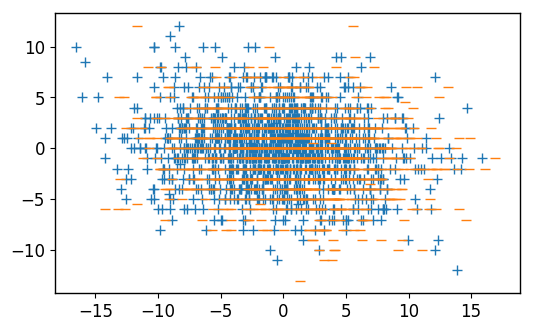

In [66]:
plt.scatter(data[data.loc[:,0]==0].iloc[:,1], data[data.loc[:,0]==0].iloc[:,2], marker='+')
plt.scatter(data[data.loc[:,0]==1].iloc[:,1], data[data.loc[:,0]==1].iloc[:,2], marker='_')

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

### Binary decision trees

In [68]:
from sklearn.tree import DecisionTreeClassifier
# different scoring metrics: http://scikit-learn.org/stable/modules/model_evaluation.html

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = dict(max_depth=range(1, 10), criterion=['gini', 'entropy'], splitter=['best', 'random'])
test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     clf = DecisionTreeClassifier(random_state=0)
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(stdsc.fit_transform(X_train), y_train)
     # predict test labels
     y_test_pred = grid.predict(stdsc.transform(X_test))
     y_test_prob = grid.predict_proba(X_test)[:,1]
     test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy, metrics.brier_score_loss(y_test, y_test_prob)

0 0.635644485807 {'splitter': 'best', 'criterion': 'entropy', 'max_depth': 4} 0.634093376764 0.237099246714
1 0.623080502559 {'splitter': 'best', 'criterion': 'entropy', 'max_depth': 3} 0.608034744843 0.234501444341
2 0.630060493253 {'splitter': 'best', 'criterion': 'gini', 'max_depth': 3} 0.623235613464 0.232733007233
3 0.60865518846 {'splitter': 'best', 'criterion': 'gini', 'max_depth': 3} 0.629750271444 0.219848474479
4 0.607724523034 {'splitter': 'random', 'criterion': 'entropy', 'max_depth': 3} 0.627578718784 0.23303938139
5 0.638901814798 {'splitter': 'best', 'criterion': 'entropy', 'max_depth': 6} 0.604777415852 0.274108712003
6 0.642159143788 {'splitter': 'best', 'criterion': 'gini', 'max_depth': 3} 0.612377850163 0.235017323692
7 0.61842717543 {'splitter': 'random', 'criterion': 'entropy', 'max_depth': 8} 0.640608034745 0.258986649077
8 0.623545835272 {'splitter': 'best', 'criterion': 'entropy', 'max_depth': 4} 0.598262757872 0.239089858587
9 0.630525825966 {'splitter': 'best'

In [69]:
np.array(test_accuracies).mean()

0.62160694896851254

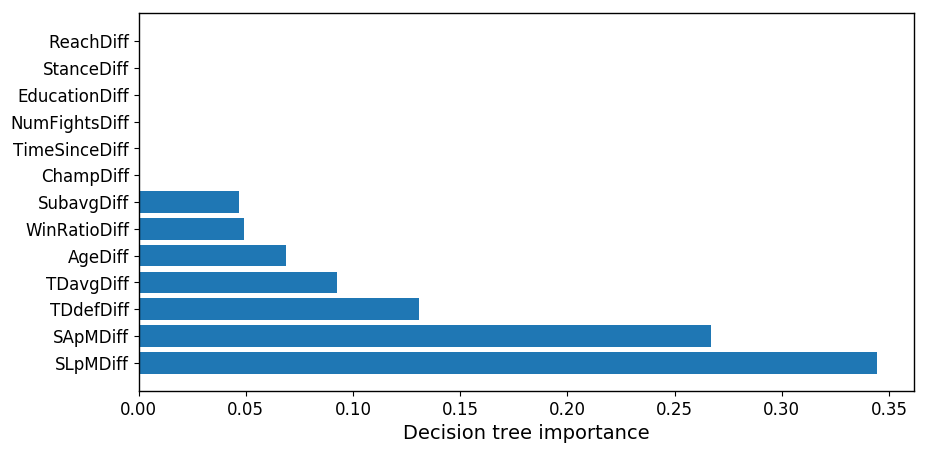

In [70]:
importances = grid.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.barh(range(X_train.shape[1]), importances[indices], align='center')
plt.yticks(range(X_train.shape[1]), gs.columns[indices], rotation=0)
plt.xlabel('Decision tree importance')

Write out the optimal tree to graph file:

In [71]:
# http://webgraphviz.com (paste contents of file here)
#from sklearn import tree
#fn = ['stance1', 'age1', 'stance2', 'age2']
#cn = ['fighter1 wins', 'fighter2 wins']
#clf.set_params(**grid.best_params_).fit(X_train, y_train)
#tree.export_graphviz(clf, out_file='tree.dot', feature_names=fn, class_names=cn)

In [72]:
# uncomment below to see log
#grid.cv_results_

### Evaluation of the classifer

In [73]:
confmat = metrics.confusion_matrix(y_test, y_test_pred)
confmat

array([[314, 169],
       [165, 273]])

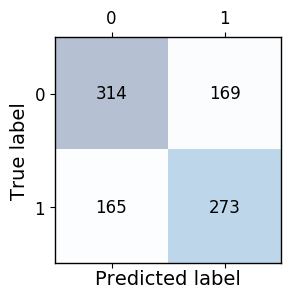

In [74]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
     for j in range(confmat.shape[1]):
          ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')

### ROC curve

In [75]:
# store the predicted probabilities for class 1 
y_pred_prob = grid.predict_proba(X_test)[:,1]

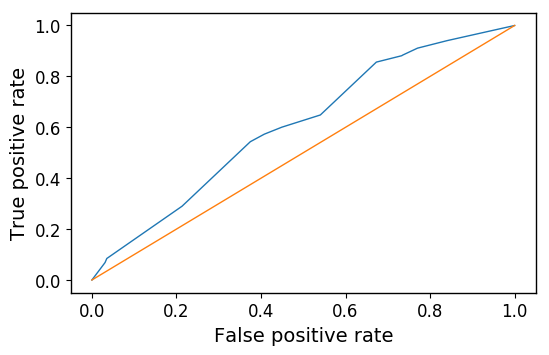

In [76]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In [77]:
metrics.roc_auc_score(y_test, y_pred_prob)

0.60678124734110439

### Accuracy is maximized at threshold is 1/2 as implied by scoring choice

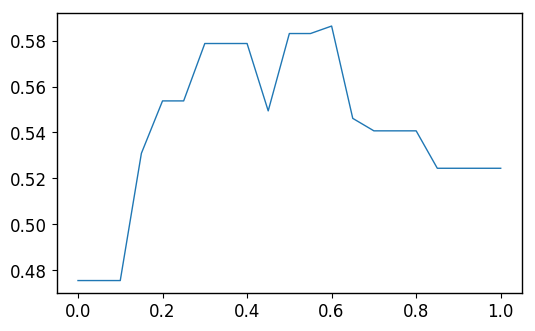

In [78]:
thresholds = np.arange(0, 1.05, 0.05)
plt.plot(thresholds, [metrics.accuracy_score(y_test, pd.Series(y_pred_prob).apply(lambda x: 0 if x < threshold else 1)) for threshold in thresholds])

### Precision vs recall

In [79]:
metrics.recall_score(y_test, y_test_pred)

0.62328767123287676

In [80]:
metrics.precision_score(y_test, y_test_pred)

0.61764705882352944

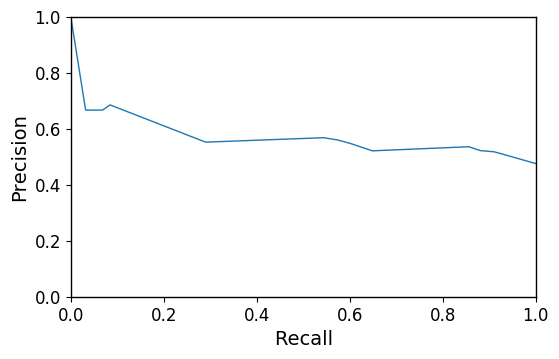

In [81]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_prob, pos_label=1)
plt.plot(recall, precision)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Recall')
plt.ylabel('Precision')

     pre = tp / (tp + fp)
     rec = tp / (tp + fn)
When precision is high we only predict 1 when we are very confident. This means we mostly predict 0 and are frequenty wrong (many FN) which means low recall. When we aggressively predict 1, we have many false positive which drops precision. Recall increases since there are few false negatives.

# Other models

### Neural nets

from sklearn.neural_network import MLPClassifier

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = dict(alpha=np.logspace(-4, 0, base=10, num=15))

test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(5, 2), random_state=1)
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(stdsc.fit_transform(X_train), y_train)
     # predict test labels
     y_test_pred = grid.predict(stdsc.transform(X_test))
     test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy

In [82]:
np.array(test_accuracies).mean()

0.62160694896851254

### Random Forest

from sklearn.ensemble import RandomForestClassifier

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = dict(criterion=['gini', 'entropy'], bootstrap=[True, False])

param_grid = {}

test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     clf = RandomForestClassifier(n_estimators=100, max_features='sqrt', bootstrap=True, oob_score=True)
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(stdsc.fit_transform(X_train), y_train)
     # predict test labels
     y_test_pred = grid.predict(stdsc.transform(X_test))
     test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy
     
print np.array(test_accuracies).mean(), grid.best_estimator_.oob_score_
importances = grid.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots(1, 1, figsize=(12,6))
plt.barh(range(X_train.shape[1]), importances[indices], align='center')
plt.yticks(range(X_train.shape[1]), gs.columns[indices], rotation=0)
plt.xlabel('Random forest importance')

### Logistic Regression

In [85]:
from sklearn.linear_model import LogisticRegression

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = dict(C=np.logspace(-4, 1, base=10, num=25), penalty=['l1', 'l2'])
test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     clf = LogisticRegression()
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(stdsc.fit_transform(X_train), y_train)
     # predict test labels
     y_test_pred = grid.predict(stdsc.transform(X_test))
     test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy

0 0.654723127036 {'penalty': 'l2', 'C': 0.0011006941712522103} 0.653637350706
1 0.666356444858 {'penalty': 'l2', 'C': 0.0011006941712522103} 0.654723127036
2 0.665891112145 {'penalty': 'l2', 'C': 0.00068129206905796151} 0.648208469055
3 0.659376454165 {'penalty': 'l2', 'C': 0.012115276586285889} 0.664495114007
4 0.659376454165 {'penalty': 'l2', 'C': 1.4677992676220706} 0.678610206298
5 0.663564448581 {'penalty': 'l1', 'C': 0.082540418526801898} 0.659066232356
6 0.6570497906 {'penalty': 'l2', 'C': 0.012115276586285889} 0.679695982628
7 0.6570497906 {'penalty': 'l2', 'C': 0.0074989420933245579} 0.650380021716
8 0.662168450442 {'penalty': 'l2', 'C': 0.0074989420933245579} 0.664495114007
9 0.661703117729 {'penalty': 'l2', 'C': 0.012115276586285889} 0.666666666667


In [86]:
np.array(test_accuracies).mean()

0.66199782844733979

In [97]:
grid.best_estimator_.coef_

array([ 0.17920229, -0.07416746, -0.1119866 , -0.03586455, -0.0478555 ,
       -0.01669091, -0.03483144, -0.08788588,  0.39763833, -0.43523959,
       -0.2268399 , -0.25186551, -0.14925715])

In [95]:
grid.best_estimator_.intercept_

array([ 0.02779232])

In [138]:
coeffs = []
c_values = np.logspace(-3, 0, base=10, num=25)
for c in c_values:
     clf = LogisticRegression(C=c, penalty='l1')
     clf.fit(stdsc.fit_transform(X_train), y_train)
     coeffs.append(clf.coef_[0])
cf = pd.DataFrame(coeffs, columns=gs.columns)

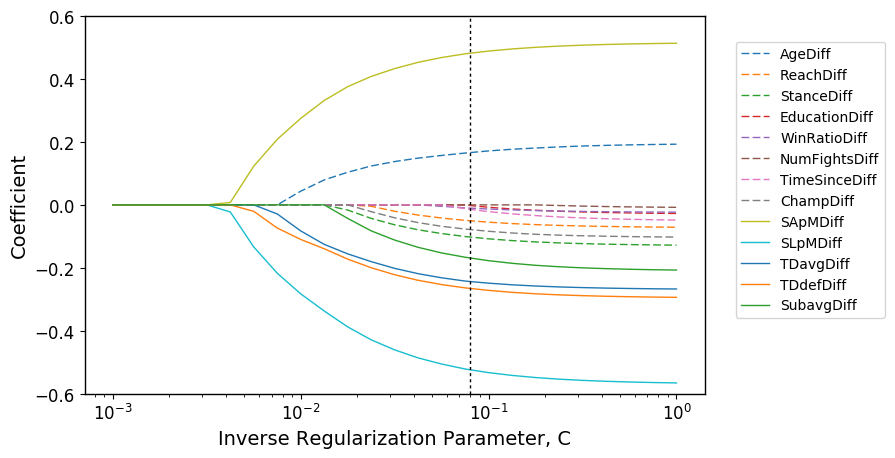

In [157]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i in range(cf.shape[1]):
     if (i > 7): plt.semilogx(c_values, cf.iloc[:,i], label=cf.columns[i])
     else: plt.semilogx(c_values, cf.iloc[:,i], label=cf.columns[i], ls='dashed')
plt.axvline(x=0.08, ymin=0, ymax=1, color='k', ls=':')
plt.ylim(-0.6, 0.6)
plt.xlabel('Inverse Regularization Parameter, C')
plt.ylabel('Coefficient')
plt.legend(loc=(1.05, 0.2))

### AdaBoost

from sklearn.ensemble import AdaBoostClassifier

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = dict(learning_rate=np.logspace(-4, 0, base=10, num=5),
                  n_estimators=[25, 50, 100],
                  base_estimator__max_depth=[1, 2, 3])
test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     tree = DecisionTreeClassifier(criterion='entropy')
     clf = AdaBoostClassifier(tree)
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(stdsc.fit_transform(X_train), y_train)
     # predict test labels
     y_test_pred = grid.predict(stdsc.transform(X_test))
     test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy

In [ ]:
np.array(test_accuracies).mean()

### KNN

from sklearn.neighbors import KNeighborsClassifier

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
# p=2 with minkowski is euclidean so omitted below
param_grid = [dict(n_neighbors=range(10, 110, 10), weights=['uniform', 'distance'],
              metric=['minkowski'], p=[1, 3, 4]),
              dict(n_neighbors=range(10, 110, 10), weights=['uniform', 'distance'],
              metric=['chebyshev', 'euclidean'])]
param_grid = [dict(n_neighbors=range(7, 35, 2), weights=['uniform', 'distance'], metric=['chebyshev', 'euclidean'])]
test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     clf = KNeighborsClassifier()
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(stdsc.fit_transform(X_train), y_train)
     # predict test labels
     y_test_pred = grid.predict(stdsc.transform(X_test))
     test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy

In [ ]:
np.array(test_accuracies).mean()

### Support Vector Classifier

from sklearn.svm import SVC
from sklearn.decomposition import PCA
pca = PCA(n_components=4)

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = [dict(kernel=['linear'],
                   C=np.logspace(-3, 3, base=10, num=15),
                   shrinking=[True, False])]
param_grid = [dict(kernel=['linear'], C=np.logspace(-3, 3, base=10, num=7))]
test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     clf = SVC(probability=True)
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(pca.fit_transform(stdsc.fit_transform(X_train)), y_train)
     # predict test labels
     y_test_pred = grid.predict(pca.transform(stdsc.transform(X_test)))
     test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy

In [ ]:
np.array(test_accuracies).mean()

### Bagged Logistic Regression

#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = dict(n_estimators=[25, 50],
                  bootstrap_features=[True, False],
                  base_estimator__C=np.logspace(-3, 3, base=10, num=15),
                  base_estimator__penalty=['l1', 'l2'])
test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     lr = LogisticRegression()
     clf = BaggingClassifier(base_estimator=lr)
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(stdsc.fit_transform(X_train), y_train)
     # predict test labels
     y_test_pred = grid.predict(stdsc.transform(X_test))
     test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy

In [ ]:
np.array(test_accuracies).mean()